In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy import integrate
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, Parameter, report_fit
from sklearn.metrics import r2_score
import random

In [2]:
#function for getting rate graphs
def change_coord(data, init,num):
    
    rate_lists = []
    
    for line in range(num):
        rate_list = []
        for i in range(len(data[line])-1):
            rate_list.append((data[line][i+1]-data[line][i])/(timespan[i+1]-timespan[i]))   
        rate_lists.append(rate_list)

    return rate_lists

In [3]:
#needed parameters
T = [323,363,393]
P = 50
KH= 1282
CH2 = P/KH
R= 8.314
timespan = [0, 1, 3, 5, 7, 9, 11, 13, 15, 19, 23, 27, 31, 40, 50, 60, 90, 120, 150, 180, 240, 300, 360, 440, 530, 620, 810, 900, 955, 1246]
time = timespan[-1]


In [4]:
#function for getting activation energy from rate constants and pre factors
def get_Eact(A, ktrue):
    T=363
    E = (np.log(ktrue/A))*R*T
    return E

In [5]:
#function for getting noise
def get_noise():
    static_noise = np.random.normal(0,0.01,30)
    variable_noise = np.random.normal(0,0.05,30)
    return static_noise, variable_noise

In [6]:
#function to run ODE simulation and make data out of it
def simulate_system(diff,pre_consts, E_acts,T, inits, full_set):
    rate_consts = pre_consts*np.exp(E_acts/(R*T))
    sol_list = []
    for init in inits:
        sol = integrate.solve_ivp(diff, [0,time], init, t_eval = timespan, args=[rate_consts])
        if full_set == False:
            sol_list.append(sol.y[0:3])
        else:
            sol_list.append(sol.y[0:4])

    noisy_data_lists = []
    i = 0
    for sol in sol_list:
        noisy_data = []
        for line in sol:
            static_noise,variable_noise = get_noise()
            noisy_data.append(line + static_noise + np.multiply(line,variable_noise))

        noisy_data_lists.append(noisy_data)

    num = len(sol_list[0])
    rate_lists = []
    for i in range(len(noisy_data_lists)):
        rate_lists.append(change_coord(noisy_data_lists[i],inits[i],num))
        i+=1
        
    return sol_list, noisy_data_lists, rate_lists

In [7]:
#function for getting r2_score more easily
def get_r2(real,simul):
    if len(simul)<4 or len(real)< 4:
        return r2_score(real[0], simul[0]) + (r2_score(real[1], simul[1])) + (r2_score(real[2], simul[2]))
    return r2_score(real[0], simul[0]) + (r2_score(real[1], simul[1])) + (r2_score(real[2], simul[2])) + (r2_score(real[3], simul[3]))

In [10]:
#get the r2_score for the real system
def true_r2(diff,pre_consts,E_acts,inits,T, noisy_data, rate_data):
    #test R squared comparison for random values
    rate_consts = pre_consts*np.exp(E_acts/(R*T))
    ind = {}
    for i in range(len(rate_consts)):
        ind[f'k{i+1}'] = rate_consts[i]
    print(ind)
    best_list = []
    for init in inits:
        best = integrate.solve_ivp(diff, [0,time], init, args = (ind,), t_eval = timespan)
        best_list.append(best.y)
        
    num = len(best_list[0])
    changed_rates = []
    for i in range(len(best_list)):
        changed_rate = change_coord(best_list[i],inits[i],num)
        changed_rates.append(changed_rate)

    score = 0
    
    for i in range(len(noisy_data)):
        score += get_r2(noisy_data[i], best_list[i])
    for i in range(len(rate_data)):
        score += get_r2(rate_data[i], changed_rates[i])
    
    return score

In [11]:
#function for converting erros to SMAPE scores
def get_SMAPE(real,sim):
    tot = 0
    for i in range(len(real)):
        tot += np.abs(np.abs(real[i])-np.abs(sim[i]))/((np.abs(real[i])+(np.abs(sim[i]))/2))
    return(tot)

In [12]:
# main workhorse of the script, guesses rate constants, and minimizes the residual of the outcome
def fit_sim(diff, inits, noisy_data, rate_data, max_score, consts):
    def residual(paras):

        """
        compute the residual between actual data and fitted data
        """
        subject = {}
        for const in consts:
            subject[const] = paras[const].value
            

        
        sol_list = []
        
        for init in inits:
            sol = integrate.solve_ivp(diff, [0,time], init, args = (subject,), t_eval = timespan)
            sol_list.append(sol.y)

        
        num = len(sol_list[0])
        changed_rates = []
        
        for i in range(len(sol_list)):
            changed_rate = change_coord(sol_list[i],inits[i], num)
            changed_rates.append(changed_rate)

        score = 0
    
        for i in range(len(noisy_data)):
            score += get_r2(noisy_data[i], sol_list[i])
        for i in range(len(rate_data)):
            score += get_r2(rate_data[i], changed_rates[i])

#         print(score)
        return max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score

    

    params = Parameters()
    for const in consts:
        params.add(const,value=0.01, min=1e-10, max=1)
    


    results = minimize(residual, params, method='leastsq', max_nfev = 1000)  # leastsq nelder

    
    fin_sub = {}
    for const in consts:
            fin_sub[const] = results.params[const].value
    
    data_fitted = integrate.solve_ivp(diff, [0,time], inits[0], args = (fin_sub,), t_eval = timespan)
    sim = residual(results.params)[0]
    score = max_score - sim
    print(sim)

    # plot fitted data
    if len(data_fitted.y) >=4 and len(noisy_data[0]) >= 4:
        plt.figure()
        plt.scatter(timespan, noisy_data[0][0], marker='o', color='b', label='measured data CE')
        plt.scatter(timespan, noisy_data[0][1], marker='o', color='b', label='measured data CA1')
        plt.scatter(timespan, noisy_data[0][2], marker='o', color='b', label='measured data CA2')
        plt.scatter(timespan, noisy_data[0][3], marker='o', color='b', label='measured data CtE')
        plt.plot(timespan, data_fitted.y[0], '-', linewidth=2, color='red', label='fitted data CE')
        plt.plot(timespan, data_fitted.y[1], '-', linewidth=2, color='red', label='fitted data CA1')
        plt.plot(timespan, data_fitted.y[2], '-', linewidth=2, color='red', label='fitted data CA2')
        plt.plot(timespan, data_fitted.y[3], '-', linewidth=2, color='red', label='fitted data CtE')
        plt.legend()
    else:
        plt.figure()
        plt.scatter(timespan, noisy_data[0][0], marker='o', color='b', label='measured data CE')
        plt.scatter(timespan, noisy_data[0][1], marker='o', color='b', label='measured data CA1')
        plt.scatter(timespan, noisy_data[0][2], marker='o', color='b', label='measured data CA2')
        plt.plot(timespan, data_fitted.y[0], '-', linewidth=2, color='red', label='fitted data CE')
        plt.plot(timespan, data_fitted.y[1], '-', linewidth=2, color='red', label='fitted data CA1')
        plt.plot(timespan, data_fitted.y[2], '-', linewidth=2, color='red', label='fitted data CA2')
        plt.legend()
    # display fitted statistics
    report_fit(results)
    
    return results.params, score

In [13]:
#for kinetic parameter fittin we need a function to synthesize rate constants out of the parameters, and then run simulations with it
def get_lines(diff,T, inits,constants):
    ind_const = {}
    half = int(len(constants)/2)
    for i in range(half):
        ind_const[f'k{i+1}'] = constants[f'A{i+1}']*np.exp(-constants[f'E{i+1}']/(R*T))

    lines_list = []
    for init in inits:
        lines = integrate.solve_ivp(diff, [0,time], init, args = (ind_const,), t_eval = timespan)
        lines_list.append(lines.y)

    return lines_list

In [14]:
#main workhorse of the script, guesses kinetic constants, and minimizes the residual of the outcome
def fit_sim_full(diff, inits, noisy_data, rate_data, max_score, temperatures, guesses, consts):
    
    pre_consts = []
    E_acts = []
    
    for i in range(len(consts)):
        pre_consts.append(f'A{i+1}')
        E_acts.append(f'E{i+1}')
        
    def residual(paras):

        """
        compute the residual between actual data and fitted data
        """
        
        subject = {}
        for pre_const in pre_consts:
            subject[pre_const] = paras[pre_const].value
        for E_act in E_acts:
            subject[E_act] = paras[E_act].value
        
        half = int(len(subject)/2)
        for i in range(half):
            val = subject[f'A{i+1}']*np.exp(-subject[f'E{i+1}']/(R*T[-1]))
            if val > 1:
                return max_score,max_score,max_score,max_score,max_score,max_score,max_score,max_score,max_score,max_score,max_score,max_score,
        
        
        lines_list = []
        rates_list = []

        for temp in temperatures:
            rates_int = []
            lines = get_lines(diff,temp,inits,subject)
            lines_list.append(lines)
            num = len(lines[0])
            for i in range(len(lines)):
                rates_int.append(change_coord(lines[i],inits[i],num))
            rates_list.append(rates_int)

        score = 0
         
        for i in range(len(noisy_data)):
            for j in range(len(noisy_data[i])):
                score += get_r2(noisy_data[i][j], lines_list[i][j])
        for i in range(len(rate_data)):
            for j in range(len(rate_data[i])):
                score += get_r2(rate_data[i][j], rates_list[i][j])                                                                            
        print(score)
        return max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score,max_score-score


    params = Parameters()
    for i in range(len(pre_consts)):
        params.add(pre_consts[i],value=guesses[1,i], min=1e-5, max=1e5)
    for i in range(len(E_acts)):
        params.add(E_acts[i],value=guesses[0,i], min=1000, max=100000)

    results = minimize(residual, params, method='leastsq', max_nfev = 200)  # leastsq nelder
    report_fit(results)
    
    sim = residual(results.params)[0]
    score = max_score - sim
    print(sim)
    
    fin_sub = {}
    for pre_const in pre_consts:
        fin_sub[pre_const] = results.params[pre_const].value
    for E_act in E_acts:
        fin_sub[E_act] = results.params[E_act].value
      
    mock_run = get_lines(diff,temperatures[0],inits,fin_sub)
    
    
    if len(mock_run[0]) >=4 and len(noisy_data[0][0]) >= 4:
        for i in range(len(temperatures)):
            data_fitted = get_lines(diff,temperatures[i],inits,fin_sub)
            plt.figure(i)
            plt.plot(timespan, data_fitted[0][0], '-', linewidth=2, color='red', label='fitted data CE')
            plt.plot(timespan, data_fitted[0][1], '-', linewidth=2, color='red', label='fitted data CA1')
            plt.plot(timespan, data_fitted[0][2], '-', linewidth=2, color='red', label='fitted data CA2')
            plt.plot(timespan, data_fitted[0][3], '-', linewidth=2, color='red', label='fitted data CtE')
            plt.scatter(timespan, noisy_data[i][0][0], marker='o', color='b', label='measured data CE')
            plt.scatter(timespan, noisy_data[i][0][1], marker='o', color='b', label='measured data CA1')
            plt.scatter(timespan, noisy_data[i][0][2], marker='o', color='b', label='measured data CA2')
            plt.scatter(timespan, noisy_data[i][0][3], marker='o', color='b', label='measured data CtE')
            plt.legend()
    else:
        for i in range(len(temperatures)):
            data_fitted = get_lines(diff,temperatures[i],inits,fin_sub)
            plt.figure(i)
            plt.plot(timespan, data_fitted[0][0], '-', linewidth=2, color='red', label='fitted data CE')
            plt.plot(timespan, data_fitted[0][1], '-', linewidth=2, color='red', label='fitted data CA1')
            plt.plot(timespan, data_fitted[0][2], '-', linewidth=2, color='red', label='fitted data CA2')
            plt.scatter(timespan, noisy_data[i][0][0], marker='o', color='b', label='measured data CE')
            plt.scatter(timespan, noisy_data[i][0][1], marker='o', color='b', label='measured data CA1')
            plt.scatter(timespan, noisy_data[i][0][2], marker='o', color='b', label='measured data CA2')
            plt.legend()


    print(residual(results.params)[0])
    
    return results.params, score

In [15]:
#class that takes the data, and the systems wit all the parameters ,and handles the fitting
class fitting_set:
    def __init__(self,true_system, sim_system, pre_constants, E_acts, sim_consts, temperatures, inits, sim_inits, full_set = False):
        self.true_system = true_system
        self.sim_system = sim_system
        self.pre_constants = pre_constants
        self.E_acts = E_acts
        self.consts = []
        
        for i in range(len(pre_constants)):
            self.consts.append(f'k{i+1}')

                
        self.sim_consts = sim_consts
        self.temperatures = temperatures
        self.inits = inits
        self.sim_inits = sim_inits
        self.sim_rates_dict = {'temp': []}
        for const in self.sim_consts:
            self.sim_rates_dict[const] = []
        self.ind_fits_scores = []
        
        self.full_set = full_set
        
    def get_true_data(self):
        self.true = []
        self.noisy = []
        self.rates = []
        for temperature in self.temperatures:
            sim = simulate_system(self.true_system,self.pre_constants,self.E_acts,temperature,self.inits, self.full_set)
            self.true.append(sim[0])
            self.noisy.append(sim[1])
            self.rates.append(sim[2])
        
    def get_true_r2(self):
        for i in range(len(self.temperatures)):
            print(true_r2(self.true_system,self.pre_constants,self.E_acts,self.inits,self.temperatures[i],self.noisy[i],self.rates[i]))
        
    def fit_sys(self,temp_num,max_score):
        fit_sim(self.sim_system, self.sim_inits, self.noisy[temp_num], self.rates[temp_num], max_score, self.sim_consts)
        
    def fit_sys_all(self,max_score):
        for i in range(len(self.temperatures)):
            fits, score = fit_sim(self.sim_system, self.sim_inits, self.noisy[i], self.rates[i], max_score, self.sim_consts)
            self.ind_fits_scores.append(score)
            self.sim_rates_dict['temp'].append(self.temperatures[i])
            for const in self.sim_consts:
                self.sim_rates_dict[const].append(fits[const].value)
                
        
    def kin_params_guesses(self):
        self.Eact_list = []
        self.A_list = []
        for variable,lis in self.sim_rates_dict.items():
            log_list = np.log(lis)
            reciprocal_list = 1/np.array(self.sim_rates_dict['temp'])
            lin_model = np.polyfit(reciprocal_list,log_list,1)
            slope = lin_model[0]
            intercept = lin_model[1]
            self.Eact_list.append(slope*8.314)
            self.A_list.append(np.exp(intercept))
        del self.Eact_list[0]
        del self.A_list[0]
        
    def fit_sys_full(self,max_score):
        guesses = np.zeros([2,len(self.Eact_list)])
        guesses[0,:] = self.Eact_list
        guesses[0,:] *= -1
        guesses[1,:] = self.A_list
        for guess in guesses[0,:]:
            if guess <1000:
                guess = 1000
        for guess in guesses[1,:]:
            if guess > 1:
                guess = 1
        fits, self.full_fit_score = fit_sim_full(self.sim_system, self.sim_inits, self.noisy, self.rates, max_score, self.temperatures, guesses, self.sim_consts)
        self.A_ests = []
        self.E_ests = []
        for i in range(int(len(fits)/2)):
            self.A_ests.append(fits[f'A{i+1}'].value)
            self.E_ests.append(fits[f'E{i+1}'].value)
            

        
    def get_final_scores(self,ind_max, full_max):
        ind_score = 0
        for i in range(len(self.temperatures)):
            ind_score += self.ind_fits_scores[i]/(ind_max*len(self.temperatures))
#         SMAPE_tot = 0
#         for key in self.real_rates_dict.keys():
#             SMAPE_tot += get_SMAPE(self.real_rates_dict[key],self.sim_rates_dict[key])
#         SMAPE_tot += get_SMAPE(self.pre_constants,self.A_ests)
#         SMAPE_tot += get_SMAPE(self.E_acts,self.E_ests)
        print(1-ind_score)
        return 1-ind_score, 1-(self.full_fit_score/full_max)#, SMAPE_tot/(len(self.consts)*5)
        
        

In [16]:
#all different used differentials
def diff_6(x, init, rate_const):
    CE, CA1, CA2, CtE,Cprecat, Ccat, Ccatdead, H2uptake = init
    try:
        k1, k2, k3, k4, k5, k6= rate_const['k1'],rate_const['k2'],rate_const['k3'],rate_const['k4'],rate_const['k5'],rate_const['k6']
    except:
        k1,k2,k3,k4,k5,k6 = rate_const
    dEdt = -k1*CE*Cprecat - k2*CE*CA1 + k3*CtE*CA2
    dA1dt = k1*CE*Cprecat - k2*CE*CA1 + k3*CtE*CA2 + 2*k4*CtE*Cprecat
    dA2dt = k1*CE*Cprecat + k2*CE*CA1 - k3*CtE*CA2
    dtEdt = k2*CE*CA1 - k3*CtE*CA2 - k4*CtE*Cprecat
    dprecatdt = -k1*CE*Cprecat - k4*CtE*Cprecat + k5*Ccat*CH2 - k6*Cprecat
    dcatdt = k1*CE*Cprecat + k4*CtE*Cprecat - k5*Ccat*CH2
    dcatdeaddt = k6*Cprecat
    dH2uptakedt = k5*Ccat*CH2
    return dEdt, dA1dt, dA2dt, dtEdt, dprecatdt, dcatdt,dcatdeaddt, dH2uptakedt

In [17]:
def diff_1(x, init, rate_const):
    CE, CA1, CA2 = init
    try:
        k1= rate_const['k1']
    except:
        k1 = rate_const[0]
    dEdt = -k1*CE
    dA1dt = k1*CE
    dA2dt = k1*CE
    return dEdt, dA1dt, dA2dt

In [18]:
def diff_2(x, init, rate_const):
    CE, CA1, CA2, Cprecat, Ccatdead = init
    try:
        k1, k2= rate_const['k1'],rate_const['k2']
    except:
        k1, k2 = rate_const
    dEdt = -k1*CE*Cprecat
    dA1dt = k1*CE*Cprecat
    dA2dt = k1*CE*Cprecat
    dprecatdt = -k2*Cprecat
    dcatdeaddt = k2*Cprecat
    return dEdt, dA1dt, dA2dt, dprecatdt, dcatdeaddt

In [19]:
def diff_3(x, init, rate_const):
    CE, CA1, CA2, Cprecat, Ccat, Ccatdead = init
    try:
        k1, k2, k3= rate_const['k1'],rate_const['k2'],rate_const['k3']
    except:
        k1, k2, k3 = rate_const
    dEdt = -k1*CE*Cprecat
    dA1dt = k1*CE*Cprecat
    dA2dt = k1*CE*Cprecat
    dprecatdt = -k1*CE*Cprecat -k3*Cprecat + k2*Ccat*CH2
    dcatdt = k1*CE*Cprecat - k2*Ccat*CH2
    dcatdeaddt = k3*Cprecat
    return dEdt, dA1dt, dA2dt, dprecatdt, dcatdt, dcatdeaddt

In [20]:
def diff_4_cat(x, init, rate_const):
    CE, CA1, CA2, Cprecat, Ccat, Ccatdead = init
    try:
        k1, k2, k3, k4= rate_const['k1'],rate_const['k2'],rate_const['k3'],rate_const['k4']
    except:
        k1, k2, k3, k4 = rate_const
    dEdt = -k1*CE*Cprecat - k2*CE*CA1*Cprecat
    dA1dt = k1*CE*Cprecat +  k2*CE*CA1*Cprecat
    dA2dt = k1*CE*Cprecat + k2*CE*CA1*Cprecat
    dprecatdt = -k1*CE*Cprecat - k2*CE*CA1*Cprecat + k3*Ccat*CH2 - k4*Cprecat
    dcatdt = k1*CE*Cprecat + k2*CE*CA1*Cprecat - k3*Ccat*CH2
    dcatdeaddt = k4*Cprecat
    return dEdt, dA1dt, dA2dt, dprecatdt, dcatdt, dcatdeaddt

In [21]:
def diff_4_tE(x, init, rate_const):
    CE, CA1, CA2, CtE, Cprecat, Ccatdead = init
    try:
        k1, k2, k3, k4= rate_const['k1'],rate_const['k2'],rate_const['k3'],rate_const['k4']
    except:
        k1, k2, k3, k4 = rate_const
    dEdt = -k1*CE*Cprecat - k2*CE*CA1
    dA1dt = k1*CE*Cprecat - k2*CE*CA1 +2*k3*CtE*Cprecat
    dA2dt = k1*CE*Cprecat + k2*CE*CA1
    dtEdt = k2*CE*CA1 - 2*k3*CtE*Cprecat
    dprecatdt = - k4*Cprecat
    dcatdeaddt = k4*Cprecat
    return dEdt, dA1dt, dA2dt, dtEdt, dprecatdt, dcatdeaddt

In [22]:
def diff_5(x, init, rate_const):
    CE, CA1, CA2, CtE,Cprecat, Ccat, Ccatdead = init
    try:
        k1, k2, k3, k4, k5 = rate_const['k1'],rate_const['k2'],rate_const['k3'],rate_const['k4'],rate_const['k5']
    except:
        k1,k2,k3,k4,k5 = rate_const
    dEdt = -k1*CE*Cprecat - k2*CE*CA1 
    dA1dt = k1*CE*Cprecat - k2*CE*CA1 + 2*k3*CtE*Cprecat
    dA2dt = k1*CE*Cprecat + k2*CE*CA1
    dtEdt = k2*CE*CA1 - k3*CtE*Cprecat
    dprecatdt = -k1*CE*Cprecat - k3*CtE*Cprecat + k4*Ccat*CH2 - k5*Cprecat
    dcatdt = k1*CE*Cprecat + k3*CtE*Cprecat - k4*Ccat*CH2
    dcatdeaddt = k5*Cprecat
    return dEdt, dA1dt, dA2dt, dtEdt, dprecatdt, dcatdt,dcatdeaddt

In [23]:
#function to make calling cartinain data and fitting systems easier
def make_systems(real,fit, full_set = False):
    init_1 = [[1,0,0], [4,0,0], [8,0,0]]
    init_2 = [[1,0,0,1,0], [4,0,0,2,0], [8,0,0,1.5,0]]
    init_3 = [[1,0,0,1,0,0], [4,0,0,2,0,0], [8,0,0,1.5,0,0]]
    init_4_cat = [[1,0,0,1,0,0], [4,0,0,2,0,0], [8,0,0,1.5,0,0]]
    init_4_tE = [[1,0,0,0,1,0], [4,0,0,0,2,0], [8,0,0,0,1.5,0]]
    init_5 = [[1,0,0,0,1,0,0], [4,0,0,0,2,0,0], [8,0,0,0,1.5,0,0]]
    init_6 = [[1,0,0,0,1,0,0,0], [4,0,0,0,2,0,0,0], [8,0,0,0,1.5,0,0,0]]
    consts = np.array([0.01209668296564242, 0.01517495478255645, 0.0042608145032644508, 0.0897487647678990227, 0.032891811706016034, 0.012690318715024702])
    pre_consts = np.array([4, 1.6, 1, 5, 2, 40])
    sim_consts = ["k1", "k2", "k3", "k4", "k5", "k6"]
    temps = ([323,363,393])
    
    if real == 1:
        diff= diff_1
        init = init_1
        sel_consts = consts[0]
        sel_pre_consts = [pre_consts[0]]
    if fit == 1:
        diff_sim = diff_1
        sim_init = init_1
        sel_sim_consts = [sim_consts[0]]
        
    if real == 2:
        diff= diff_2
        init = init_2
        sel_consts = np.array([consts[0],consts[5]])
        sel_pre_consts = np.array([pre_consts[0],pre_consts[5]])
    if fit == 2:
        diff_sim = diff_2
        sim_init = init_2
        sel_sim_consts = sim_consts[0:2]
        
    if real == 3:
        diff= diff_3
        init = init_3
        sel_consts = np.array([consts[0],consts[4],consts[5]])
        sel_pre_consts = np.array([pre_consts[0],pre_consts[4],pre_consts[5]])
    if fit == 3:
        diff_sim = diff_3
        sim_init = init_3
        sel_sim_consts = sim_consts[0:3]
        
    if real == 4:
        diff= diff_4_cat
        init = init_4_cat
        sel_consts = np.array([consts[0],consts[1],consts[4],consts[5]])
        sel_pre_consts = np.array([pre_consts[0],pre_consts[1],pre_consts[4],pre_consts[5]])
    if fit == 4:
        diff_sim = diff_4_cat
        sim_init = init_4_cat
        sel_sim_consts = sim_consts[0:4]
        
    if real == 5:
        diff= diff_4_tE
        init = init_4_tE
        sel_consts = np.array([consts[0],consts[1],consts[3],consts[5]])
        sel_pre_consts = np.array([pre_consts[0],pre_consts[1],pre_consts[3],pre_consts[5]])
    if fit == 5:
        diff_sim = diff_4_tE
        sim_init = init_4_tE
        sel_sim_consts = sim_consts[0:4]
        
    if real == 6:
        diff= diff_5
        init = init_5
        sel_consts = np.array([consts[0],consts[1],consts[3],consts[4],consts[5]])
        sel_pre_consts = np.array([pre_consts[0],pre_consts[1],pre_consts[3],pre_consts[4],pre_consts[5]])
    if fit == 6:
        diff_sim = diff_5
        sim_init = init_5
        sel_sim_consts = sim_consts[0:5]
    
    if real == 7:
        diff= diff_6
        init = init_6
        sel_consts = np.array([consts[0],consts[1],consts[2],consts[3],consts[4],consts[5]])
        sel_pre_consts = np.array([pre_consts[0],pre_consts[1],consts[2],pre_consts[3],pre_consts[4],pre_consts[5]])
    if fit == 7:
        diff_sim = diff_6
        sim_init = init_6
        sel_sim_consts = sim_consts[0:]
    
    
    E_acts = get_Eact(sel_pre_consts,sel_consts)
    return fitting_set(diff,diff_sim,sel_pre_consts,E_acts, sel_sim_consts, temps,init, sim_init, full_set)

In [25]:
#make a system that has system3 proide data, and fits system 1 to it
exp_1 = make_systems(3,1,True)

In [74]:
exp_1.get_true_data()

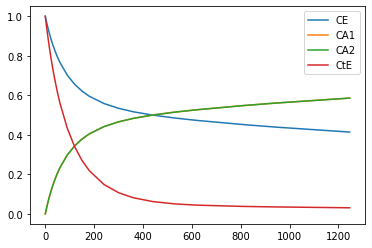

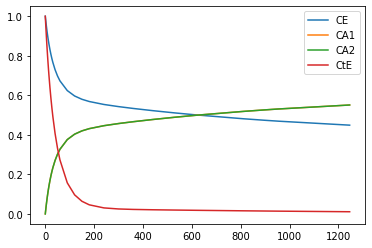

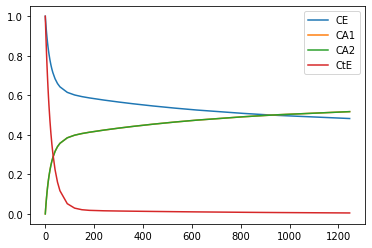

In [76]:
#check plots
for exp in exp_1.true:
    plt.figure()
    plt.plot(timespan,exp[0][0], label = 'CE')
    plt.plot(timespan,exp[0][1], label = 'CA1')
    plt.plot(timespan,exp[0][2], label = 'CA2')
    if len(exp[0]) == 4:
        plt.plot(timespan,exp[0][3], label = 'CtE')
#     plt.plot(timespan,exp[0][4], label = 'Cprecat')
#     plt.plot(timespan,exp[0][5], label = 'Ccat')
#     plt.plot(timespan,exp[0][6], label = 'Ccatdead')
    plt.legend()

In [50]:
#check real r2
exp_1.get_true_r2()

{'k1': 0.005897488188304271}
11.535556262796291
{'k1': 0.01209668296564243}
13.290017303552826
{'k1': 0.01883590224472234}
13.528923427679612


6.463885659066106
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14
    # data points      = 6
    # variables        = 1
    chi-square         = 250.690907
    reduced chi-square = 50.1381814
    Akaike info crit   = 24.3947676
    Bayesian info crit = 24.1865271
[[Variables]]
    k1:  0.00585138 +/- 7.83349985 (133874.49%) (init = 0.01)
4.707212671672183
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12
    # data points      = 6
    # variables        = 1
    chi-square         = 132.947107
    reduced chi-square = 26.5894214
    Akaike info crit   = 20.5891513
    Bayesian info crit = 20.3809108
[[Variables]]
    k1:  0.01189267 +/- 955.211814 (8031935.98%) (init = 0.01)
4.465868253135488
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # data points      = 6
    # variables        = 1
    chi-square         = 119.663876
    reduced chi-square = 23.9327751
    Akaike info crit   = 19.957

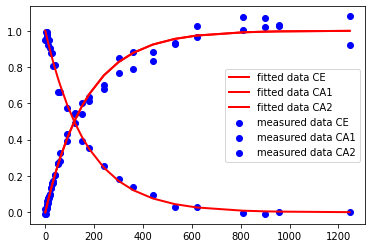

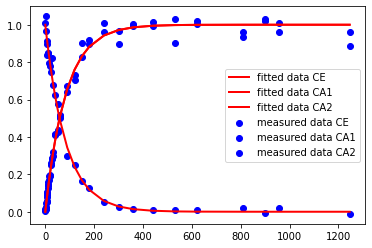

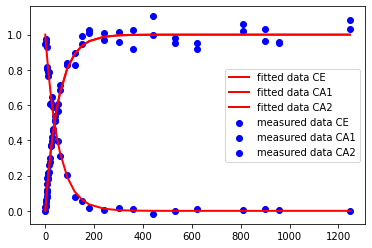

In [52]:
#do per temperature fits
#exp_1.fit_sys(1,24)
exp_1.fit_sys_all(18)

# exp_1.fit_sys_all(18)
#exp_1.fit_sys_full(72)

In [54]:
#guess kinetics from that
exp_1.kin_params_guesses()

In [56]:
print(exp_1.sim_rates_dict)
print(exp_1.Eact_list)
print(exp_1.A_list)


{'temp': [323, 363, 393], 'k1': [0.00585137610129682, 0.011892672153969492, 0.018386125863732526]}
[-17263.83031317368]
[3.6250817374854263]


In [57]:
print(exp_1.pre_constants)
print(exp_1.E_acts)

[4.0]
[-17507.67079081]


38.3630280810799
38.3630280810799
38.3630280810799
38.36302808359063
38.363028080980015
-69.064136379461
-62.93493503349394
-1257.2131835948019
34.48159749717517
38.329010982464304
38.362694676507
38.36302498648595
38.36302807362765
38.3630280810799
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 12
    # variables        = 2
    chi-square         = 2934.17869
    reduced chi-square = 293.417869
    Akaike info crit   = 69.9913145
    Bayesian info crit = 70.9611278
##  Warning: uncertainties could not be estimated:
    A1:  at initial value
    E1:  at initial value
[[Variables]]
    A1:  3.62508174 (init = 3.625082)
    E1:  17263.8303 (init = 17263.83)
38.3630280810799
15.636971918920104
38.3630280810799
15.636971918920104


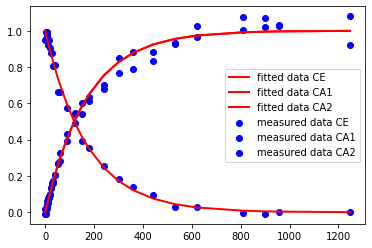

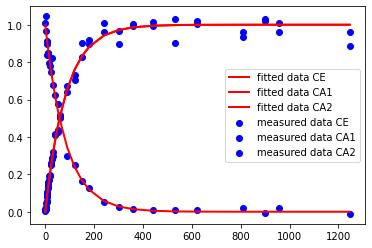

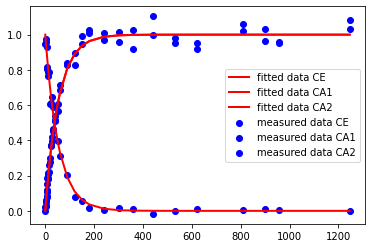

In [59]:
#simultaneous fitting of all datasets
# exp_1.fit_sys_full(54)
exp_1.fit_sys_full(54)

In [61]:
# exp_1.get_final_scores(18,54)
exp_1.get_final_scores(18,54)

0.2895734552569218


(0.2895734552569218, 0.28957355405407603)

In [ ]:
print(exp_1.real_rates_dict)
print(exp_1.sim_rates_dict)

7.4084666731436855
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 388
    # data points      = 6
    # variables        = 6
    chi-square         = 329.312271
    reduced chi-square = 329.312271
    Akaike info crit   = 36.0314819
    Bayesian info crit = 34.7820387
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k1:  0.00610554 (init = 0.01)
    k2:  0.00854614 (init = 0.01)
    k3:  0.00421408 (init = 0.01)
    k4:  0.05767746 (init = 0.01)
    k5:  0.02002816 (init = 0.01)
    k6:  0.00484116 (init = 0.01)
6.027126852013659
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1000
    # data points      = 6
    # variables        = 6
    chi-square         = 217.957549
    reduced chi-square = 217.957549
    Akaike info crit   = 33.5552451
    Bayesian info crit = 32.3058019
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k1:  0.01235452 (init = 0.01)
    k2:  0.01497650 (init = 0.01)
  

5.027645206246007
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1000
    # data points      = 6
    # variables        = 6
    chi-square         = 151.663298
    reduced chi-square = 151.663298
    Akaike info crit   = 31.3794207
    Bayesian info crit = 30.1299775
##  Warning: uncertainties could not be estimated:
[[Variables]]
    k1:  0.01912330 (init = 0.01)
    k2:  0.02121442 (init = 0.01)
    k3:  0.00404162 (init = 0.01)
    k4:  0.10162657 (init = 0.01)
    k5:  0.04562866 (init = 0.01)
    k6:  0.02227187 (init = 0.01)
51.31991661536776
51.31991661536776
51.31991661536776
51.31992010531678
51.31989168033647
51.32033211275706
51.31991958731688
51.31993378374642
51.31991425985673
51.31991647554113
51.31991721010467
51.319916615367745
51.31991648581239
51.31991610408004
51.319916879590394
-43.91456116154214
39.818867235767094
39.788236301941986
51.31991661536776
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 16
    # 

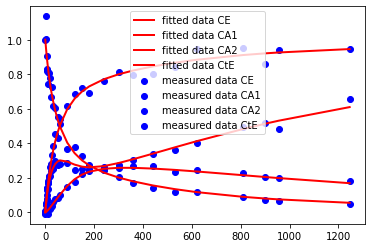

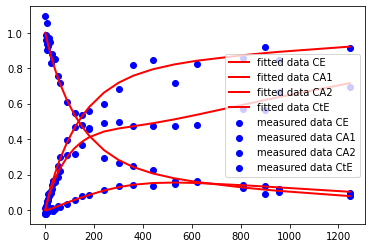

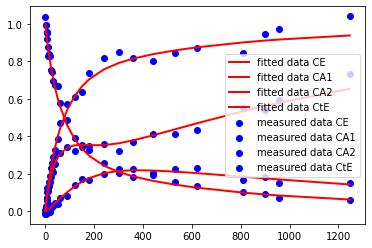

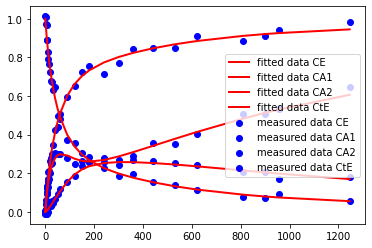

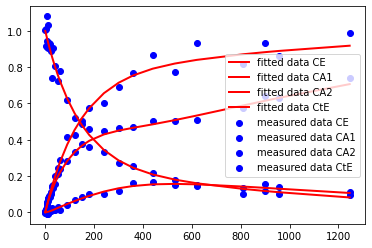

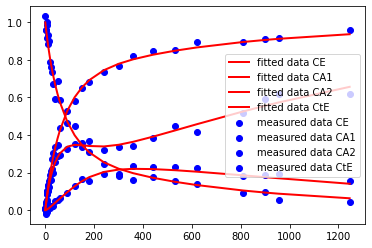

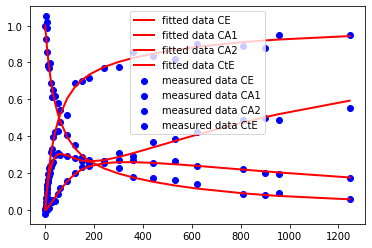

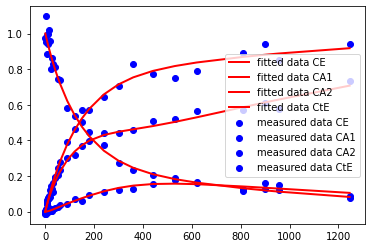

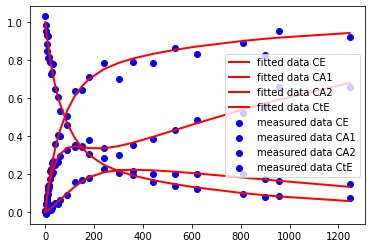

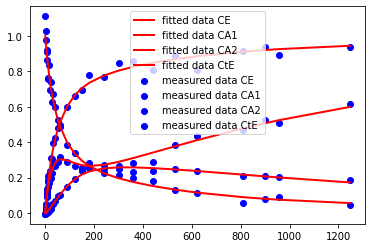

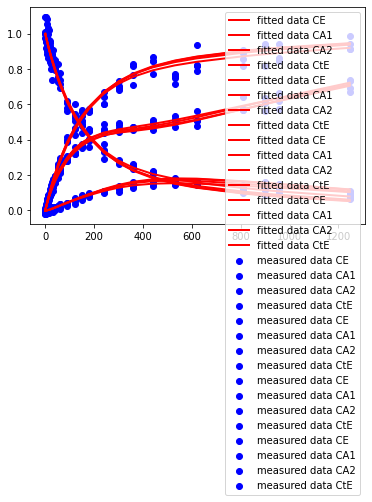

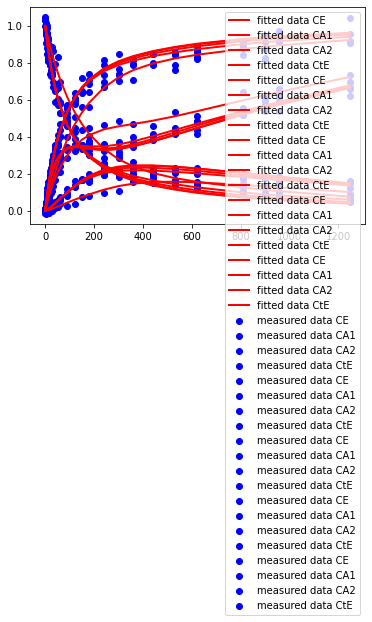

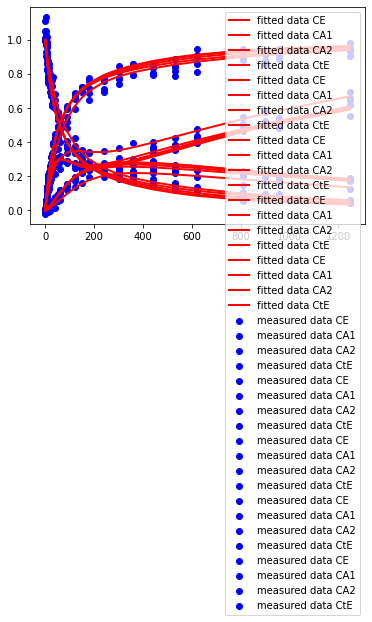

In [111]:
#block for running everything consecutively
res_lis = []
for i in range(4):
    exp_1 = make_systems(7,7,True)
    exp_1.get_true_data()
    exp_1.fit_sys_all(24)
    exp_1.kin_params_guesses()
    exp_1.fit_sys_full(54)
    score = exp_1.get_final_scores(24,72)
    res_lis.append(score)
print(res_lis)

In [112]:
print(res_lis)

[(0.27030592729025804, 0.27466430657409147), (0.2674409957972326, 0.2676132317334544), (0.2733525959764005, 0.2872233803421145), (0.2670528161349309, 0.28255195843432057)]
